# Specie distribution

In [33]:
import os

# import numpy as np
import pandas as pd 
import geopandas as gpd
import elapid as ela

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader


In [34]:
figsize = (18,12)
projection = ccrs.PlateCarree()

def make_map(figsize, projection, res):

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)

    ax.add_feature(cfeature.BORDERS.with_scale(res)) # , color='gray'
    ax.add_feature(cfeature.STATES.with_scale(res),
                   linestyle=':', edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale(res), color='lightgray')
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    
    gl = ax.gridlines(color='grey', linestyle=':', draw_labels=True, rotate_labels=False) #ylocs=[-45, -60, -75])
    
    return fig, ax, gl

## 1. Species Occurrence

In [35]:
data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
out_path = os.path.join(os.sep, 'mnt', 'jmeijer_workspace', 'checkouts', 'aciar', 'out')
input_path = os.path.join(out_path, 'input')
if not os.path.exists(input_path):
    os.makedirs(input_path)

In [36]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'thaumastocoris-peregrinus' #'leptocybe-invasa' # 
# region = 'australasia' #'east-asia'
training = 'australia'
interest = 'south-east-asia'

###########################################################

In [37]:
regions = {
    'east-asia': ['China', 'Taiwan', 'Japan', 'North Korea', 'South Korea'],
    'south-east-asia': ['Brunei', 'Myanmar', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'melanesia': ['Fiji', 'Vanuatu', 'Solomon Islands', 'Papua New Guinea'],
    'australia': ['Australia']
}

In [38]:
# file_name_gbif = 'Gbif_L-invasa_0120814-230530130749713.csv'
# file_name_cabi = 'Cabi_2017_L-invasa-108923.csv'
# # file_name_eppo = 'Eppo_2010_L-invasa.csv' # presence only on state level, no coordinates
# file_name_otieno = 'Otieno_2019_L-invasa.csv'
# file_name_peng = 'Peng_2021_L-invasa.csv'

In [39]:
# gbif = pd.read_csv(os.path.join(data_path, 'species', specie, file_name_gbif), sep='\t', usecols=['decimalLatitude', 'decimalLongitude', 'eventDate'])#	day	month	year])
# cabi = pd.read_csv(os.path.join(data_path, 'species', specie, file_name_cabi), skiprows=2, usecols=['Latitude', 'Longitude', 'First Reported', 'References'], na_values='Not recorded')
# # eppo = pd.read_csv(os.path.join(data_path, 'species', specie, file_name_eppo), usecols=['country', 'state', 'country code', 'state code', 'Status', 'continent'])
# otieno = pd.read_csv(os.path.join(data_path, 'species', specie, file_name_otieno), usecols=['Lat', 'Lon', 'Origin'])
# peng = pd.read_csv(os.path.join(data_path, 'species', specie, file_name_peng), usecols=['Lat', 'Lon', 'Date', 'Elevation (m)'])

In [40]:
# gbif_renamed = gbif.rename(columns={'decimalLatitude':'lat', 'decimalLongitude': 'lon', 'eventDate': 'date'})
# gbif_renamed['source'] = 'GBIF'
# cabi_renamed = cabi.rename(columns={'Latitude':'lat', 'Longitude': 'lon', 'First Reported': 'date'})
# cabi_renamed['source'] = 'CABI'
# otieno_renamed = otieno.rename(columns={'Lat':'lon', 'Lon': 'lat'})
# otieno_renamed['source'] = 'Otieno et al. 2019'
# peng_renamed = peng.rename(columns={'Lat':'lat', 'Lon': 'lon', 'Date': 'date'})
# peng_renamed['source'] = 'Peng et al. 2021'
# occurences_global = pd.concat([gbif_renamed, cabi_renamed, otieno_renamed, peng_renamed])

In [41]:
occurences_global = pd.read_csv(os.path.join(data_path, 'species', specie, '%s_aggregated.csv' %specie))
print('Number of occurences globally is: %s' %len(occurences_global))

Number of occurences globally is: 979


In [42]:
# make geopandas dataframe
geometry = gpd.points_from_xy(occurences_global['lon'], occurences_global['lat'])
occurences = gpd.GeoDataFrame(occurences_global['source'], geometry=geometry)

# drop occurences without coordinates
occurences = occurences[~occurences.is_empty]
print('Number of occurences globally after removing occurrences without coordinates: %s' %len(occurences))

Number of occurences globally after removing occurrences without coordinates: 936


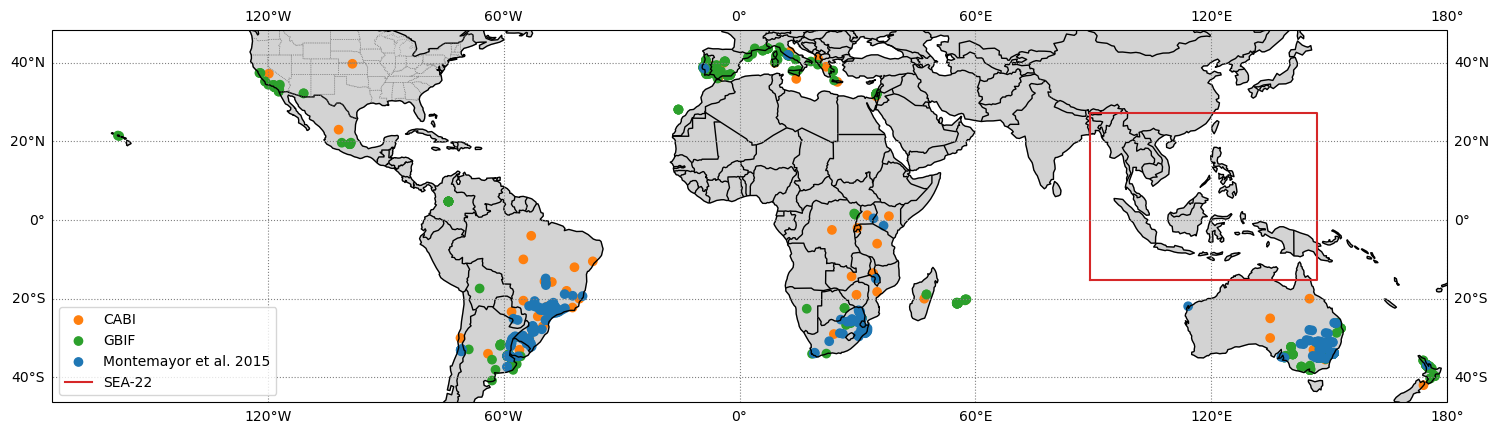

In [43]:
colors = list(mcolors.TABLEAU_COLORS.keys())
dict_color = {src: colors[i]  for i, src in enumerate(occurences.source.unique())}
occurences['color'] = occurences['source'].map(dict_color)

fig, ax, gl = make_map(figsize, projection, res='110m')

for src, df in occurences.groupby('source'):
    ax.scatter(x=df.geometry.x, y=df.geometry.y, color=df.color, label=src, transform=ccrs.PlateCarree())

ax.plot([89.26, 146.96, 146.96, 89.26, 89.26], [-15.14, -15.14, 27.26, 27.26, -15.14], transform=ccrs.PlateCarree(), label='SEA-22', color='tab:red')   
ax.legend(loc='lower left')

## 2. Define Training Area

In [44]:
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
countries = gpd.read_file(shpfilename)

In [45]:
# select and combine countries in one dataframe
gdf_countries = gpd.GeoDataFrame()
for country in regions[training]:
    cntry = countries.loc[countries['ADMIN'] == country]
    gdf_countries = pd.concat([gdf_countries, cntry])
    
gdf_countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
225,Admin-0 country,1,2,Australia,AU1,1,2,Country,1,Australia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((143.17891 -11.95449, 143.15293..."


In [46]:
# write basemap to shape file
if not os.path.exists(input_path):
    os.makedirs(input_path)
gdf_countries.to_file(os.path.join(input_path, '%s.shp' %training))

In [47]:
in_region = occurences.within(gdf_countries.geometry.values[0])
for i in range(1, len(gdf_countries)-1):
    in_region = in_region | occurences.within(gdf_countries.geometry.values[i])
occurences_region = occurences[in_region]
print('Number of occurences in %s is: %s' %(training, len(occurences_region)))

Number of occurences in australia is: 236


In [48]:
occurences_region['lon'] = occurences_region['geometry'].x
occurences_region['lat'] = occurences_region['geometry'].y
occurences_region.to_csv(os.path.join(input_path, '%s_presence_%s.csv' %(specie, training)), columns=['lon', 'lat'], index=False)

/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


load host data (Eucalyptus) from Abbasi et al. 2023
https://www.nature.com/articles/s41597-023-02383-w

In [49]:
if training == 'east-asia':
    planted_forest_file = os.path.join('zip://', data_path, 'species', 'planted-forest-east-asia', 'planted-forest-east-asia.zip')
    eucalyptus_forest = gpd.read_file(planted_forest_file, where="Genus='Eucalyptus'")

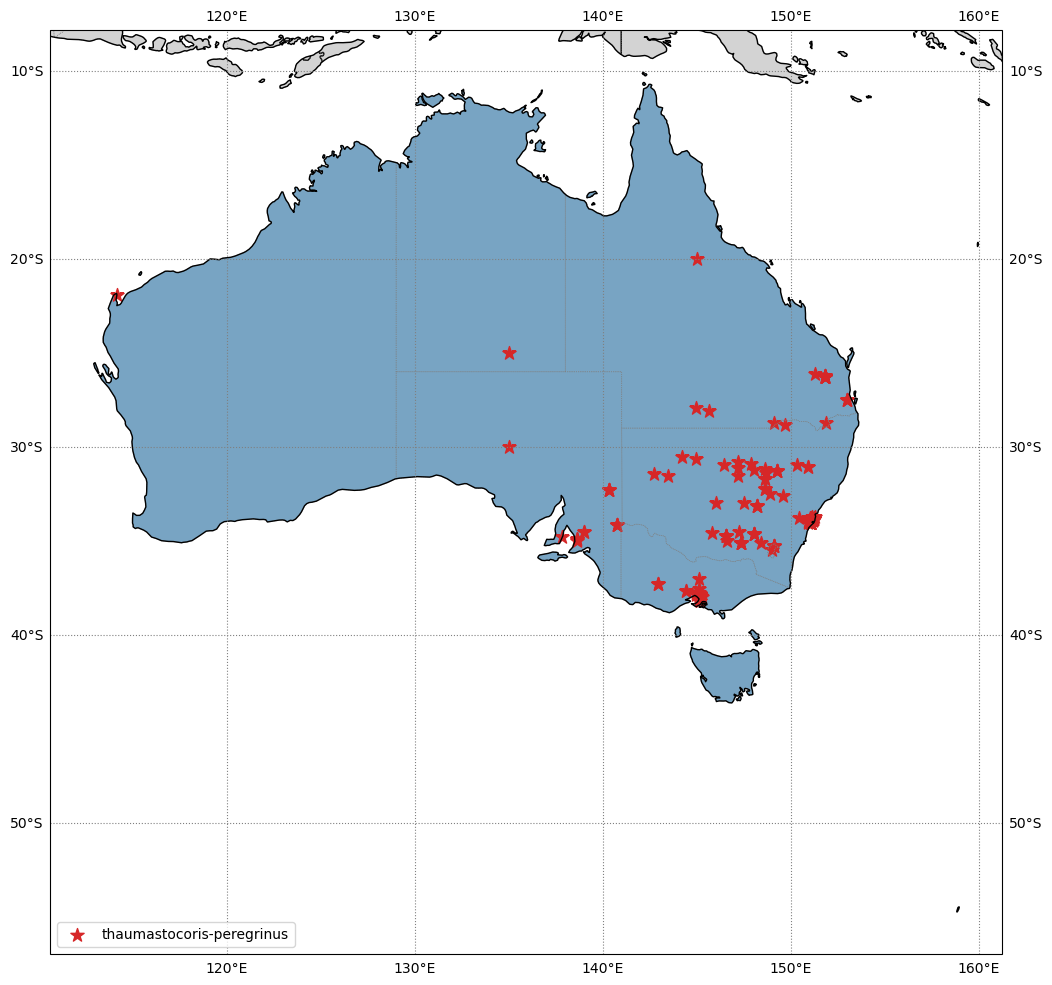

In [50]:
fig, ax, gl = make_map(figsize, projection, res='50m')

gdf_countries.plot(ax=ax, alpha=0.5)
if training == 'east-asia':
    eucalyptus_forest.plot(ax=ax, color='tab:green', label='Planted Eucalyptus')
occurences_region.plot(ax=ax, marker='*', markersize=100, color='tab:red', label=specie)

ax.legend(loc='lower left')

## 3. Define Area of Interest

In [51]:
# region = 'south-east-asia'

In [52]:
# select and combine countries in one dataframe
gdf_countries_interest = gpd.GeoDataFrame()
for country in regions[interest]:
    cntry = countries.loc[countries['ADMIN'] == country]
    gdf_countries_interest = pd.concat([gdf_countries_interest, cntry])
gdf_countries_interest.to_file(os.path.join(input_path, '%s.shp' %interest))

In [53]:
in_interest = occurences.within(gdf_countries_interest.geometry.values[0])
for i in range(1, len(gdf_countries_interest)-1):
    in_interest = in_interest | occurences.within(gdf_countries_interest.geometry.values[i])
occurences_interest = occurences[in_interest]
print('Number of occurences in %s is: %s' %(interest, len(occurences_interest)))

Number of occurences in south-east-asia is: 0


In [54]:
occurences_interest['lon'] = occurences_interest['geometry'].x
occurences_interest['lat'] = occurences_interest['geometry'].y
occurences_interest.to_csv(os.path.join(input_path, '%s_presence_%s.csv' %(specie, interest)), columns=['lon', 'lat'], index=False)

/tmp/ipykernel_2630925/1608648153.py:4: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  occurences_interest.plot(ax=ax, marker='*', markersize=100, color='tab:red', label=specie)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


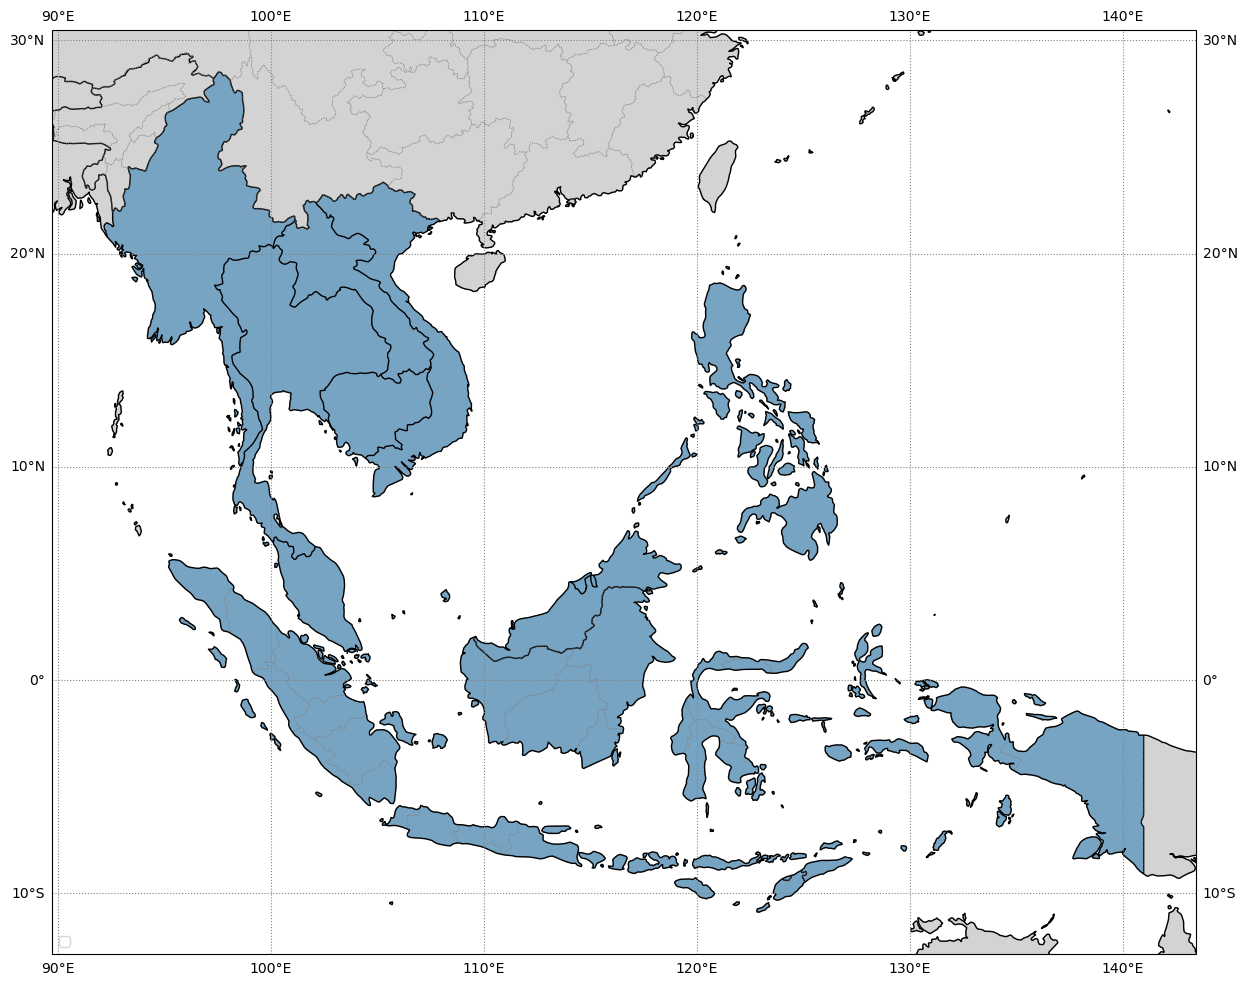

In [55]:
fig, ax, gl = make_map(figsize, projection, res='50m')

gdf_countries_interest.plot(ax=ax, alpha=0.5)
occurences_interest.plot(ax=ax, marker='*', markersize=100, color='tab:red', label=specie)

ax.legend(loc='lower left')
# ax.set_extent([90, 145, -15, 30], crs=ccrs.PlateCarree())